# rolling_correlations.ipynb
Functions to examine rolling correlations between device sensor outputs.

Author: – Jon Clucas, 2017 <jon.clucas@childmind.org>
	
© 2017, Child Mind Institute, Apache v2.0 License

#### Define functions:

In [79]:
#!/usr/bin/env python3
"""
rolling_correlation.py

Functions to calculate and plot rolling correlation values pairwise between
wearable device data streams.

Created on Fri Apr 21 16:28:13 2017

@author: jon.clucas
"""
%matplotlib inline
from config import organized_dir
from datetime import datetime, timedelta
from plot_normalized_vector_lengths import baseshift_and_renormalize
import os, pandas as pd, sys
precision_dict = {'year':-6, 'month':-5, 'week': -4, 'day': -3, 'hour':-2,
                  'minute':-1, 'second':0, 'decisecond':1, 'centisecond':2,
                  'millisecond':3, 'microsecond':4, 'nanosecond':5,
                  'picosecond':6}

def only_matching_ts_points(s0, s1, precision='second'):
    """
    Function to match time-series data streams point for point to the lowest
    resolution.
    
    Parameters
    ----------
    s0 : pandas dataframe
        time-series data stream
        
    s1 : pandas dataframe
        time-series data stream
        
    precision : int or string
        if int, the number of decimal places of a fractional second; if string,
        the time unit of resolution to match to.
        
    Returns
    -------
    m0: pandas dataframe
        time-series data with precision matching m2
    
    m1 : pandas dataframe
        time-series data with precision matching m1
    """
    if isinstance(precision, str):
        precision = int(precision_dict[precision])
    if precision < 0:
        sys.exit("Matching precision less than second is not yet implemented")
    m0 = combine_extra_precision(s0, precision)
    m1 = combine_extra_precision(s1, precision)
    return(m0, m1)
    
def combine_extra_precision(df, decimals):
    """
    Function to combine precision beyond the comparable limit.
    
    Parameters
    ----------
    df : pandas dataframe
        time series data
        
    decimals : int
        the number of decimal places of a fractional second to include
        
    Returns
    -------
    df : pandas dataframe
        time series data with resolution reduced to specified level of
        precision
    """
    if(decimals == 0):
        df[['Timestamp']] = df.Timestamp.apply(lambda x: datetime(x.year,
                            x.month, x.day, x.hour, x.minute, x.second))
    else:
        df[['Timestamp']] = df.Timestamp.apply(lambda x: datetime(x.year,
                            x.month, x.day, x.hour, x.minute, x.second,
                            x.microsecond.round(decimals)))
    df = pd.DataFrame(df.groupby(by='Timestamp')[list(df.columns)[1]].mean())
    return(df)

def r_corr(devices, sensor, start, stop):
    """
    Function to calculate rolling correlations between two sensor data streams.
    
    Parameters
    ----------
    devices : list of strings (len 2)
        each string is the name of one of the two devices to compare
        
    sensor : string
        the sensor to compare
        
    start : datetime
        beginning of time to compare
        
    stop : datetime
        end of time to compare
        
    Returns
    -------
    df : pandas dataframe
        merged dataframe with a column per device
    """
    if sensor == 'accelerometer':
        suffix = '_normalized_unit.csv'
    else:
        suffix = '.csv'
    s0 = pd.read_csv(os.path.join(organized_dir, sensor, ''.join([devices[0],
         suffix])), usecols=['Timestamp', 'normalized_vector_length'],
         parse_dates=['Timestamp'], infer_datetime_format=True)
    s0 = s0.loc[(s0['Timestamp'] >= start) & (s0['Timestamp'] <= stop)].copy()
    s1 = pd.read_csv(os.path.join(organized_dir, sensor, ''.join([devices[1],
         suffix])), usecols=['Timestamp', 'normalized_vector_length'],
         parse_dates=['Timestamp'], infer_datetime_format=True)
    s1 = s1.loc[(s1['Timestamp'] >= start) & (s1['Timestamp'] <= stop)].copy()
    # m0, m1 = only_matching_ts_points(s0, s1, 'second')
    s0 = baseshift_and_renormalize(s0)
    s1 = baseshift_and_renormalize(s1)
    s1[['Timestamp']] = s1.Timestamp.apply(lambda x: x - timedelta(microseconds
                        =1000))
    s0.set_index('Timestamp', inplace=True)
    s1.set_index('Timestamp', inplace=True)
    df = s0.merge(s1, left_index=True, right_index=True, suffixes=(''.join([
         '_', devices[0]]), ''.join(['_', devices[1]])))
    return(df)
    # correls = df.rolling(window=180, center=True).corr()
    # print(correls.loc[:, list(df.columns)[0], list(df.columns)[1]].dropna(
    #      ).mean())
    # correls.loc[:, list(df.columns)[0], list(df.columns)[1]].plot()
    # df.rolling(window=2, center=True).corr().sum().plot()

#### One day:

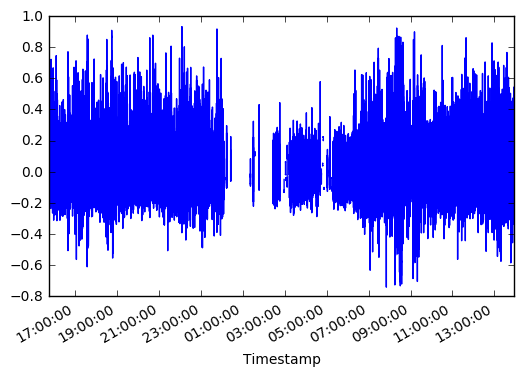

In [15]:
r_corr(['GENEActiv_pink', 'Actigraph'], 'accelerometer',  datetime(2017, 4, 6,
       15, 45), datetime(2017, 4, 7, 14, 8))

#### Thirty minutes:

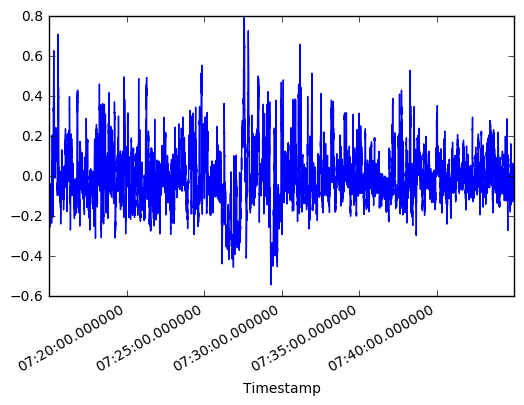

In [16]:
r_corr(['GENEActiv_pink', 'Actigraph'], 'accelerometer',  datetime(2017, 4, 7,
       7, 15), datetime(2017, 4, 7, 7, 45))

In [83]:
df = r_corr(['GENEActiv_pink', 'Actigraph'], 'accelerometer',  datetime(2017, 4, 6,
         15, 45), datetime(2017, 4, 7, 14, 8))
pdcorr = df.corr(method='pearson')
print(pdcorr)

                                         normalized_vector_length_GENEActiv_pink  \
normalized_vector_length_GENEActiv_pink                                 1.000000   
normalized_vector_length_Actigraph                                      0.253536   

                                         normalized_vector_length_Actigraph  
normalized_vector_length_GENEActiv_pink                            0.253536  
normalized_vector_length_Actigraph                                 1.000000  


In [84]:
df = r_corr(['GENEActiv_pink', 'Actigraph'], 'accelerometer',  datetime(2017, 4, 7,
       7, 15), datetime(2017, 4, 7, 7, 45))
pdcorr = df.corr(method='pearson')
print(pdcorr)

                                         normalized_vector_length_GENEActiv_pink  \
normalized_vector_length_GENEActiv_pink                                  1.00000   
normalized_vector_length_Actigraph                                       0.12423   

                                         normalized_vector_length_Actigraph  
normalized_vector_length_GENEActiv_pink                             0.12423  
normalized_vector_length_Actigraph                                  1.00000  


In [ ]:
endtime = datetime(2017, 4, 7, 14, 8)
starttime = datetime(2017, 4, 6, 15, 45)
while starttime < endtime:
    print(r_corr(['GENEActiv_pink', 'Actigraph'], 'accelerometer', starttime, starttime + timedelta(minutes=30)).corr(method='pearson'))
    starttime = starttime + timedelta(minutes=30)

In [66]:
import numpy as np
import matplotlib.pylab as plt
timestamps = np.array(list(datetime(2017, 4, 6, 15, 45) + timedelta(microseconds=1600*i) for i in range(4770)))
sin1 = np.sin(range(4770))

In [91]:
timestamps2 = timestamps + timedelta(microseconds=1000)
r2 = np.array(range(4770)) + 0.001
sin2 = np.sin(r2)

In [92]:
dfsin1 = pd.DataFrame({'Timestamp': timestamps, 'sin': sin1})
dfsin2 = pd.DataFrame({'Timestamp': timestamps2, 'sin': sin2})
dfsin2[['Timestamp']] = dfsin2.Timestamp.apply(lambda x: x - timedelta(microseconds
                        =1000))
dfsin1.set_index('Timestamp', inplace=True)
dfsin2.set_index('Timestamp', inplace=True)
dfsins = dfsin1.merge(dfsin2, left_index=True, right_index=True, suffixes=(1, 2))

In [93]:
# correls = dfsins.rolling(window=180, center=True).corr()
# print(correls.loc[:, list(df.columns)[0], list(df.columns)[1]].dropna(
#      ).mean())
# correls.loc[:, list(dfsins.columns)[0], list(dfsins.columns)[1]].plot()
dfcorr = dfsins.corr(method='pearson')
print(dfcorr)

          sin1      sin2
sin1  1.000000  0.999999
sin2  0.999999  1.000000


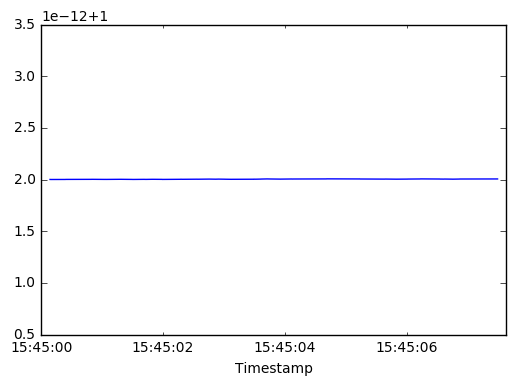

In [77]:
dfsame = dfsin1.merge(dfsin1, left_index=True, right_index=True, suffixes=('1a', '1b'))
correls = dfsame.rolling(window=180, center=True).corr()
# print(correls.loc[:, list(df.columns)[0], list(df.columns)[1]].dropna(
#      ).mean())
correls.loc[:, list(dfsame.columns)[0], list(dfsame.columns)[1]].plot()